In [ ]:
'''
Analysis file. Methods do various things like
'''

In [2]:
'''
method name: readFileToArray
args:
- filestr: a string of the file name and location
returns:
- radec: array of right ascension (ra) and declination (dec) positioning info for each object in the file. Useful as objects are saved with their ra-dec as their file names.
- mjd: the MJD date which was associated with each object in the file
'''

%matplotlib inline

def readFileToArray(filestr):
    with open(filestr) as f:
        content = f.readlines()
    content = [x.strip() for x in content]
    radec = [x.split(',')[0] for x in content]
    mjd = [x.split(',')[1] for x in content]
    return radec, mjd



In [3]:
import os
import csv

def getRowsFromFile(directorystr, filename):
    directory = os.fsencode(directorystr)
    filelist = os.listdir(directory)
    readdata = []
    for file in filelist:
        filestr = os.fsdecode(file)
        if(filestr == filename): #this is the file we want
            readfile = open(directorystr+filestr, 'r')
            lines = csv.reader(readfile)
            rowCount = 0
            for row in enumerate(lines):
                if rowCount >= 5: #mjd
                    readdata.append(row[1])
                rowCount = rowCount + 1
    return(readdata)

def getRowsFromFileALL(directorystr):
    directory = os.fsencode(directorystr)
    filelist = os.listdir(directory)
    readdata = []
    for file in filelist:
        filestr = os.fsdecode(file)
        #if(filestr == filename): #this is the file we want
        readfile = open(directorystr+filestr, 'r')
        lines = csv.reader(readfile)
        rowCount = 0
        for row in enumerate(lines):
            if rowCount >= 5: #mjd
                readdata.append(row[1])
            rowCount = rowCount + 1
    return(readdata)
                    
#result = getRowsFromFile("./csvfiles/quasar_trialset/", "19.918756_0.84493633.csv")                
#mjd = result[0]
#w1 = result[1]
#w1s = result[2]
#w2 = result[3]
#w2s = result[4]

In [31]:
'''
-find flagged objects by name
-retrieve deltaW values adjacent to flag event
-records objects with continued candidacy as <radec>,<mjdflag>,<firstFlag>,<lastFlag>
--where first and last flag indicate that the anomaly was at the ends of the observation period
'''
import numpy as np
from operator import itemgetter

def reorderArray(arrayX, arrayY):
    zipped = np.column_stack((arrayX, arrayY))
    sortedarray = sorted(zipped, key=itemgetter(0), reverse=False)
    separate = [list(t) for t in zip(*sortedarray)]
    return separate

flaglist = readFileToArray("quasarflags_3sigma.txt")
radecf = flaglist[0]
mjdf = flaglist[1]
print("Length of initial candidate list: ")
print(len(radecf))

STD = 0.256+0.315 #std w1 and std w2 for group (quasars)

notable = []

flagcount = 0
for i in range(len(radecf)): #for each flagged file, (i)
    result = getRowsFromFile("./csvfiles/quasar_trialset/", radecf[i])

    #read each row of the flagged file into an array
    mjd = []
    w1 = []
    w1s = []
    w2 = []
    w2s = []
    nullFiltered = np.zeros((5, len(result[0])+1))
    mjd = [float(x) for x in result[0]]   
    for x in result[2]:
        if x != 'null':
            w1.append(float(x))
        else:
            w1.append(99)
    for x in result[4]:
        if x != 'null':
            w1s.append(float(x))
        else:
            w1s.append(99)
    for x in result[6]:
        if x != 'null':
            w2.append(float(x))
        else:
            w2.append(99)
    for x in result[8]:
        if x != 'null':
            w2s.append(float(x))
        else:
            w2s.append(99)
            
    deltaW = [x - y for x,y in zip(w1, w2)] #calculate our deltaW

    reordered = reorderArray(mjd, deltaW) #put the list in chrono order
    mjd = reordered[0] #put it back into useful bits
    deltaW = reordered[1]
    for k, m in enumerate(mjd): #find column with date from mjdf in mjd of file 
        if (float(m) - float(mjdf[i])) == 0:
            firstFlag = 0
            lastFlag = 0
            try:
                prevmjd = mjd[k-1]
            except IndexError:
                firstFlag = 1
                flagcount  = flagcount + 1
                continue
            prevarr = [] #arrays to hold the adjacent values
            postarr = []
            ndx = k
            
            #collect the values in two arrays:
            while(prevmjd > (mjd[k] - 1095)) and ndx >= 0:
                ndx = ndx - 1
                try:
                    prevarr.append(deltaW[ndx])
                    prevmjd = mjd[ndx]
                except IndexError:
                    prevarr.append(deltaW[ndx+1])
                    firstFlag = 1
                    flagcount  = flagcount + 1
                    break
            ndx = k
            try:
                postmjd = mjd[k+1]
            except IndexError:
                lastFlag = 1
                flagcount  = flagcount + 1
                continue
            while(postmjd < (mjd[k] + 1095)):
                ndx = ndx + 1
                try:
                    postarr.append(deltaW[ndx])
                    postmjd = mjd[ndx]
                except IndexError:
                    postarr.append(deltaW[ndx-1])
                    lastFlag = 1
                    flagcount  = flagcount + 1
                    break
                    
            #now, find the ranges over the prev/post months
            try:
                postmax = max(postarr)
                postmin = min(postarr)
            except ValueError: # the object must at the end of the list
                eventPair = (radecf[i], mjdf[k])
                notable.append(eventPair) #just add this object, since data is cut off
                continue #move on to next
            try:
                prevmax = max(prevarr)
                prevmin = min(prevarr)
            except ValueError: # the object is at the beginning of the list
                eventPair = (radecf[i], mjdf[k])
                notable.append(eventPair)
                continue
                
            if (postmax-postmin) < 2*STD and (prevmax-prevmin) < 2*STD: # or, your criteria here
                eventPair = (radecf[i], mjdf[k])
                notable.append(eventPair)
            

print("Length of candidate list after filtering:")
print(len(notable))
    

Length of initial candidate list: 
1369
Length of candidate list after filtering :
401
1369


In [35]:
'''
-save our 'notable' list to file
'''
print(notable[0])
print(notable[0][0])

f = open('quasarflags_3sigma_3years.txt', 'w') # your filename here
for i in range(len(notable)):
    f.write(notable[i][0]+','+str(notable[i][1])+'\n')
f.close()
print("Done")

('123.865169901_23.8695685687.csv', '55486.6106585')
123.865169901_23.8695685687.csv
Done


In [ ]:
'''
-check these values against both models
-to what end though
'''

xdgmmG = xdgmm.XDGMM(filename='galaxyModel2018-03-28.fit')
xdgmmQ = xdgmm.XDGMM(filename='quasarModel2018-03-29.fit')




In [40]:
'''
-computes means and stds of w1, w2 etc
'''

import numpy as np

def doRowAverage(directorystr, filename):
    result = getRowsFromFile(directorystr, filename)
    w1 = np.linspace(0, len(result[2]))
    w1s = np.linspace(0, len(result[2]))
    w2 = np.linspace(0, len(result[2]))
    w2s = np.linspace(0, len(result[2]))
    j = 0
    for i in range(len(result[2])):
        try:
            w1[j] = (float(result[2][i]))
            w1s[j] = (float(result[4][i]))
            w2[j] = (float(result[6][i]))
            w2s[j] = (float(result[8][i]))
            
        except ValueError:
            continue
        j = j + 1
    w1 = w1[:j]
    w1s = w1s[:j]
    w2 = w2[:j]
    w2s = w2s[:j]
    if j == 0:
        return 0
    deltaW = [x - y for x,y in zip(w1,w2)]
    mdeltaW = np.mean(deltaW)
    mw1 = np.mean(w1)
    mw1s = np.mean(w1s)
    mw2 = np.mean(w2)
    mw2s = np.mean(w2s)
    return mw1, mw1s, mw2, mw2s, mdeltaW

mw1 = []
mw2 = []
mw1s = []
mw2s = []
mdeltaW = []

directorystr = "./csvfiles/galaxies/"
directory = os.fsencode(directorystr)
filelist = os.listdir(directory)
readdata = []
fileCount = 0
for file in filelist:
    filestr = os.fsdecode(file)
    fileCount = fileCount + 1
    try:
        result = doRowAverage(directorystr, filestr)
        if result == 0:
            continue #blank file
        else:
            mw1.append(result[0])
            mw1s.append(result[1])
            mw2.append(result[2])
            mw2s.append(result[3])
            mdeltaW.append(result[4])
    except UnicodeDecodeError:
        continue
    except IndexError:
        print("IndexError")
        print(filestr)
        #print(filecount)
        continue
    
        
# print(np.mean(mw1))
# print(np.std(mw1))
# print(np.mean(mw1s))
# print(np.std(mw1s))
    
# print(np.mean(mdeltaW))
# print(np.std(mdeltaW))
    

KeyboardInterrupt: 

In [73]:
print(np.mean(mw1s)) #average std on W1
print(np.mean(mw2s)) #average std on W2

# i.e. the acceptable fluctuation in these values across an object's history

0.0933147048896
0.200067245675


In [52]:
lightcurveresult = getRowsFromFile("./", "29.9901518_0.5528789.csv")

# for testing: 29.9901518_0.5528789, an identified clq

In [53]:
import matplotlib.pyplot as plt

mjd = [float(x) for x in lightcurveresult[0]]
w1 = np.zeros(len(lightcurveresult[2]))
w2 = np.zeros(len(lightcurveresult[6]))
w1s = np.zeros(len(lightcurveresult[4]))
w2s = np.zeros(len(lightcurveresult[8]))
i = 0
for x in lightcurveresult[2]:
    try:
        w1[i] = float(x)
        i = i + 1
    except ValueError:
        w1[i] = 0.0
        i = i + 1
i = 0
for x in lightcurveresult[6]:
    try:
        w2[i] = float(x)
        i = i + 1
    except ValueError:
        w2[i] = 0.0
        i = i + 1
i = 0
for x in lightcurveresult[4]:
    try:
        w1s[i] = float(x)
        i = i + 1
    except ValueError:
        w1s[i] = 0.0
        i = i + 1        
i = 0
for x in lightcurveresult[8]:
    try:
        w2s[i] = float(x)
        i = i + 1
    except ValueError:
        w2s[i] = 0.0
        i = i + 1
deltaW = [x - y for x,y in zip(w1,w2)]
sigW = [x + y for x,y in zip(w1s,w2s)]


[['55210.72858', '55210.79467', '55398.25424', '55398.38641', '55575.92687', '55575.99296', '55211.32414', '55397.39433', '55397.92341', '55397.98963', '55398.05572', '55210.59627', '55576.45583', '55576.45596', '55575.72848', '55575.86078', '55211.0594', '55211.19171', '55397.79111', '55397.85733', '55210.86088', '55576.12526', '55576.19135', '55575.464', '55575.59617', '55210.9271', '55210.99319', '55397.65881', '55397.65893', '55210.7948', '55398.12193', '55398.38654', '55572.95098', '55576.05905', '55576.05918', '55397.5265', '55397.52663', '55210.46384'], ['W1: ', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ''], ['15.114', '15.031', '15.029', '15.126', '15.068', '15.053', '15.142', '15.259', '14.863', '15.25', '15.353', '15.078', '15.129', '14.901', '15.278', '14.842', '15.289', '15.035', '15.031', '14.871', '15.27', '15.115', '15.204', '15.041', '14.839', '15.014', '14.954', '14.99

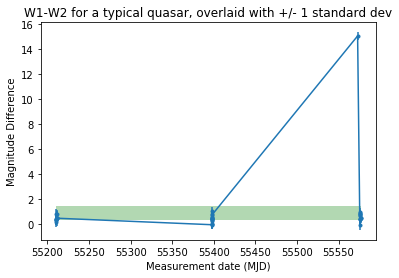

In [65]:
from operator import itemgetter

def reorderArray(arrayX, arrayY):
    zipped = np.column_stack((arrayX, arrayY))
    sortedarray = sorted(zipped, key=itemgetter(0), reverse=False)
    separate = [list(t) for t in zip(*sortedarray)]
    return separate

def addArrayToPlot(baseArr, newArr, arrCount):
    #if len(baseArr) > len(newArr):
    for i in range(len(baseArr)):
        baseArr[i] = (baseArr[i] + newArr[i])/arrCount

results = reorderArray(mjd, deltaW)
omitzero = [x for x in results[1] if x<10]
omitzerox = results[0]
mean = np.mean(results[1])
stdup = [mean + 0.25646+0.3151995 for x in results[1]]
stddown = [mean - (0.25646+0.3151995) for x in results[1]]
x = np.linspace(0, len(results[1]), len(results[1]))
plt.errorbar(results[0], results[1], yerr=sigW, marker='.')
plt.fill_between(results[0], stdup, stddown, facecolor='green', alpha=0.3)
plt.xlabel("Measurement date (MJD)")
plt.ylabel("Magnitude Difference")
plt.title("W1-W2 for a typical quasar, overlaid with +/- 1 standard dev")
